In [1]:
import pandas as pd
from pathlib import Path
import random
import torch_geometric
import json

In [2]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
parent_parent_dir = os.path.dirname(parent_dir)

sys.path.append(parent_dir)
sys.path.append(parent_parent_dir)

from utils import GenerationModule, MolGen, tensor_to_smiles

In [3]:
# read the configs
name1 = 'GNN1_charged_kekulized'
epoch1 = 0
name2 = 'GNN2_charged_kekulized'
epoch2 = 0
name3 = 'GNN3_charged_kekulized'
epoch3 = 0
config1_path = Path('..') / 'Train' / 'GNN1' / 'config_GNN1.json'
config2_path = Path('..') / 'Train' / 'GNN2' / 'config_GNN2.json'
config3_path = Path('..') / 'Train' / 'GNN3' / 'config_GNN3.json'

# Read the config as a json

with open(config1_path, 'r') as f:
    config1 = json.load(f)
with open(config2_path, 'r') as f:
    config2 = json.load(f)
with open(config3_path, 'r') as f:
    config3 = json.load(f)


In [4]:
GNN1_path = Path('.') / 'models/trained_models/GNN1_checkpoint_5.pt'
GNN2_path = Path('.') / 'models/trained_models/GNN2_checkpoint_2.pt'
GNN3_path = Path('.') / 'models/trained_models/GNN3_checkpoint_5.pt'

module = GenerationModule(config1=config1, config2=config2, config3=config3, encoding_size = 13, edge_size = 3, pathGNN1=GNN1_path, pathGNN2=GNN2_path, pathGNN3=GNN3_path, checking_mode=True)

In [5]:
module.generate_mol_list(300)


100%|██████████| 300/300 [02:51<00:00,  1.75it/s]


[DataBatch(x=[13, 13], edge_index=[2, 26], edge_attr=[26, 3], batch=[13], ptr=[2]),
 DataBatch(x=[22, 13], edge_index=[2, 46], edge_attr=[46, 3], batch=[22], ptr=[2]),
 DataBatch(x=[25, 13], edge_index=[2, 56], edge_attr=[56, 3], batch=[25], ptr=[2]),
 DataBatch(x=[24, 13], edge_index=[2, 50], edge_attr=[50, 3], batch=[24], ptr=[2]),
 DataBatch(x=[15, 13], edge_index=[2, 30], edge_attr=[30, 3], batch=[15], ptr=[2]),
 DataBatch(x=[25, 13], edge_index=[2, 54], edge_attr=[54, 3], batch=[25], ptr=[2]),
 DataBatch(x=[14, 13], edge_index=[2, 30], edge_attr=[30, 3], batch=[14], ptr=[2]),
 DataBatch(x=[23, 13], edge_index=[2, 50], edge_attr=[50, 3], batch=[23], ptr=[2]),
 DataBatch(x=[19, 13], edge_index=[2, 40], edge_attr=[40, 3], batch=[19], ptr=[2]),
 DataBatch(x=[21, 13], edge_index=[2, 48], edge_attr=[48, 3], batch=[21], ptr=[2]),
 DataBatch(x=[19, 13], edge_index=[2, 38], edge_attr=[38, 3], batch=[19], ptr=[2]),
 DataBatch(x=[22, 13], edge_index=[2, 46], edge_attr=[46, 3], batch=[22], pt

In [6]:
list_non_valid = module.non_valid_molecules

In [7]:
len(list_non_valid)

1

In [8]:
import torch
from rdkit import Chem
from rdkit.Chem import Draw

def tensor_to_mol(tensors, tensor_to_smiles):
    mol_list = []
    for tensor in tensors:
        smiles = tensor_to_smiles(tensor.x, tensor.edge_index, tensor.edge_attr)
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        mol_list.append(mol)
    return mol_list

In [9]:
import matplotlib.pyplot as plt
import math

def draw_mols(mol_list):
    # determine the number of rows needed
    rows = math.ceil(len(mol_list) / 6)
    fig, axs = plt.subplots(rows, 6, figsize=(20, rows * 3.5))  # Adjust the figure size accordingly
    axs = axs.flatten()  # To handle the 2D nature of axs when we have more than one row
    for i, mol in enumerate(mol_list):
        img = Draw.MolToImage(mol)
        axs[i].imshow(img)
        axs[i].axis('off')

    # If there are less molecules than subplots, we can hide the extra ones
    if len(mol_list) < len(axs):
        for ax in axs[len(mol_list):]:
            ax.axis('off')

    plt.tight_layout()  # optional, makes the plot look a bit nicer
    plt.show()

In [10]:
# convert a list of torch in a list of smiles 
def to_smiles_list(graph_list):
    smiles_list = []
    for mol in graph_list:
        smiles = tensor_to_smiles(mol.x, mol.edge_index, mol.edge_attr)
        smiles_list.append(smiles)
    return smiles_list

In [16]:
list_non_valid[0][-1].edge_attr

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [11]:
to_smiles_list(list_non_valid[0])[-1]

'[o-][n+](O)O'

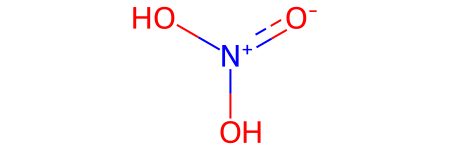

In [12]:
Chem.MolFromSmiles(to_smiles_list(list_non_valid[0])[-1], sanitize=False)

In [43]:
# Export SMILES in smi format 

smiles_list = [
    'Cc1nc(-c2nccn2)sc1C1CCCCC[NH+]1C',
]
with open("output.smi", "w") as file:
    for smiles in smiles_list:
        file.write(smiles + "\n")

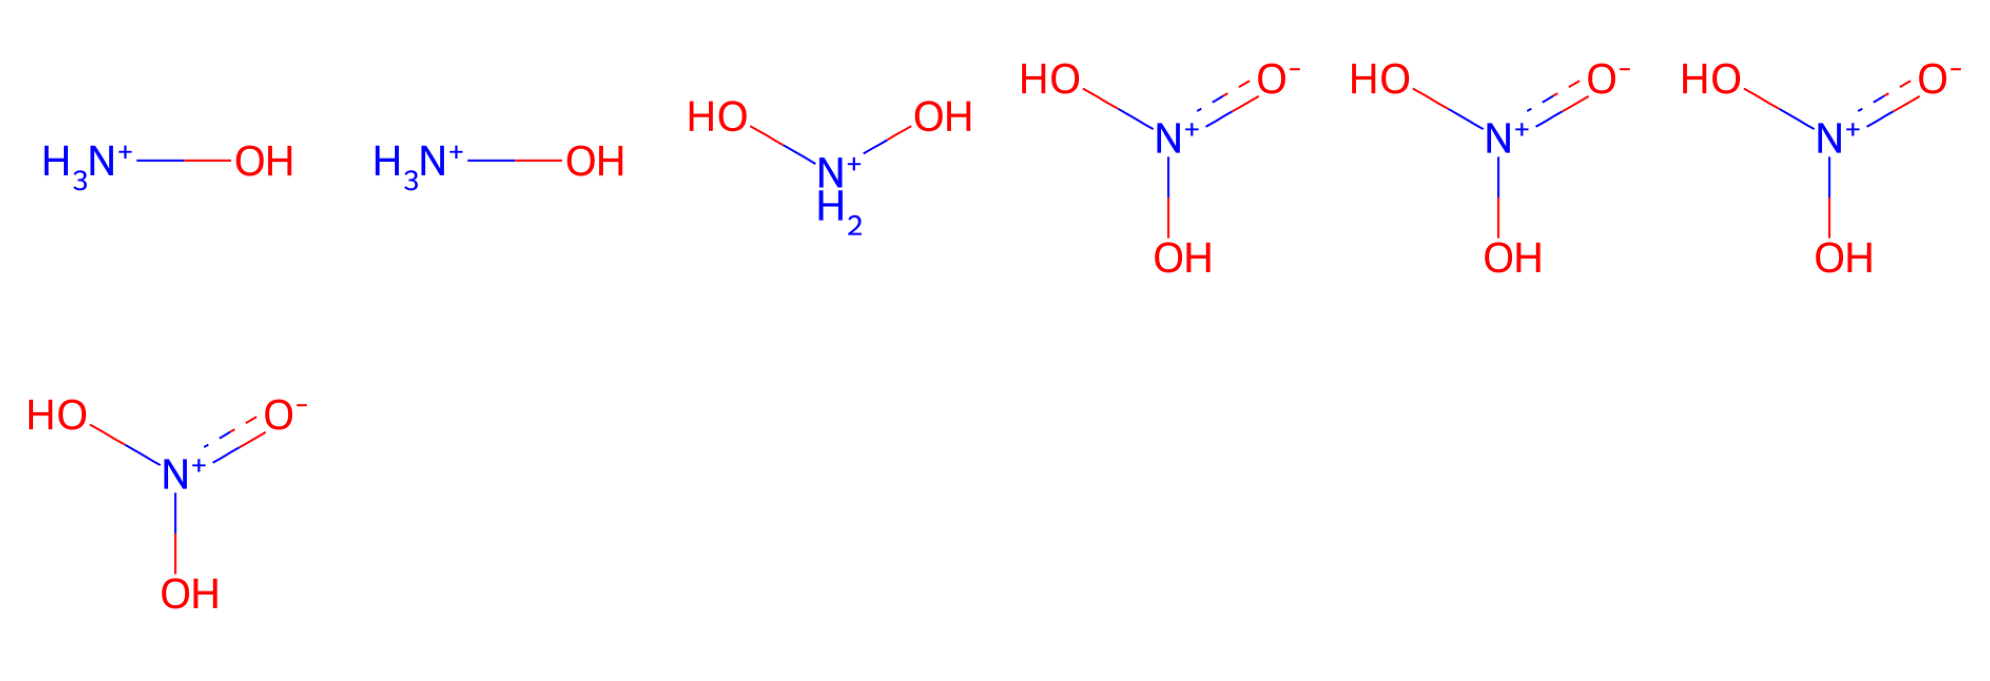

In [13]:
mol_list = tensor_to_mol(list_non_valid[0], tensor_to_smiles)
draw_mols(mol_list)

In [48]:
Chem.MolFromSmiles('Clc1ccc(C2CC3SC4=NC(c5ccc6ncnc6c5)=NC4=C3C3CC=CC32)cc1')

[16:27:43] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20


In [35]:
Chem.SanitizeMol(Chem.MolFromSmiles('Cc1cc(N(C)C)ccc1NC(=O)c1cnc2nccc(Cl)c12'))

[15:25:38] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22


ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.SanitizeMol(NoneType)
did not match C++ signature:
    SanitizeMol(class RDKit::ROMol {lvalue} mol, unsigned __int64 sanitizeOps=rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, bool catchErrors=False)